이전 챕터에서 공부했던 내용 중 이번 챕터에서 필요한 내용 가져오기

In [1]:
class SingleLayer :
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2
        
    def activation(self, z) :
        z = np.clip(z, -100, None)
        a = 1 / (1 + np.exp(-z))
        return a
        
    def score(self, x, y):
        return np.mean(self.predict(x) == y.reshape(-1, 1))
        
    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w**2)    
        
    def update_val_loss(self, x_val, y_val):
        if x_val is None:
            return
        val_loss = 0
        for i in range(len(x_val)):
            z = self.forpass(x_val[i])
            a = self.activation(z)
            a = np.clip(a, 1e-10, 1-1e-10)
            val_loss += -(y_val[i]*np.log(a) + (1-y_val[i])*np.log(1-a))
        self.val_losses.append(val_loss/len(y_val) + self.reg_loss())

<h1>6.1 신경망 알고리즘을 벡터화하여 한 번에 전체 샘플 사용</h1>

사이킷런의 예제 데이터 세트는 2차원 배열로 저장되어 있음.<br>
머신러닝은 이렇게 훈련 데이터를 2차원 배열로 표현하는 경우가 많음.<br>
이번엔 행렬 개념을 신경망 알고리즘에 도입해 봄.

<h3>6.1.1 벡터화된 연산은 알고리즘의 성능을 올림.</h3>

넘파이, 머신러닝, 딥러닝 패키지들은 다차원 배열의 계산을 빠르게 수행할 수 있음. (행렬 연산을 빠르게 수행함)<br>
이런 기능을 벡터화(vectorization)된 연산이라고 하며, 이를 이용해 알고리즘의 성능을 높일 수 있음.<br>
배치 경사 하강법을 SingleLayer 클래스에 적용하면 벡터화된 연산을 사용할 수 있음.<br>

1. 배치 경사 하강법으로 성능을 올림.<br>


지금까지는 경사 하강법 알고리즘들(선형 회귀, 로지스틱 회귀)은 알고리즘을 1번 반복할 때 1개의 샘플을 사용하는 '확률적 경사 하강법'을 사용함.<br>
SingleLayer 클래스에도 확률적 경사 하강법을 사용함.<br>
확률적 경사 하강법은 가중치를 1번 업데이트할 때 1개의 샘플을 사용하므로 손실 함수의 전역 최솟값을 안정적으로 찾음.<br>
단, 배치 경사 하강법은 가중치 1번 업데이트에 사용되는 데이터 개수가 많으므로 알고리즘 수행의 계산 비용이 많이 듦.<br>

지금부터 배치 경사 하강법을 사용하기 위한 벡터화된 연산의 기초를 알아봄.

<h3>6.1.2 벡터 연산과 행렬 연산을 알아봄</h3>

신경망에서 자주 사용하는 스칼라 곱(점 곱)과 행렬 곱셈에 대해 알아봄.<br>

1. 스칼라 곱

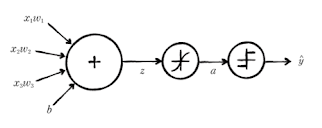

우리는 SingleLayer 클래스에서 z 값(forpass 메서드)을 구할 때 다음과 같이 구함.<br>

z = np.sum(x * self.w) + self.b<br>

위 식에서 가중치의 곱을 x * self.w 로 간단하게 표현할 수 있는 이유는 넘파이의 원소별 곱셈 기능 덕분임.<br>
이는 다음의 원리로 가중치와 입력의 곱에 대한 합을 한 번에 계산할 수 있었던 것임.

x = \[x1, x2, ..., xn\]<br>
w = \[w1, w2, ..., wn\]<br>
x * w = \[x1\*w1, x2\*w2, ..., xn\*wn\]<br>

이때 x(x1, x2, ...)와 w(w1, w2, ...)는 벡터라고 부르고 벡터는 볼드로 표기함.<br>
두 벡터를 곱하여 합을 구하는 계산 (np.sum(x * self.w))을 점 곱(dot product) 또는 스칼라 곱(scalar product) 이라고 함.<br>

다음은 단일층 신경망에 점 곱을 적용하여 다시 그린 것임.

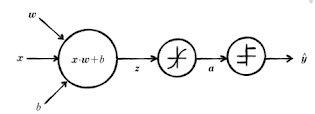

2. 스칼라 곱을 행렬 곱셈으로 표현함

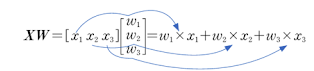

행렬의 곱셈 방식은 앞에서 본 np.sum(x * self.w)의 계산과 정확히 일치함.<br>
행렬의 곱셈을 계산하는 넘파이의 np.dot() 함수를 사용하면 np.sum(x * self.w)를 다음과 같이 수정할 수 있음.<br>

z = np.dot(x, self.w) + self.b <br>

위 행렬의 곱셈 원리를 훈련 데이터의 전체 샘플에 대해 적용하면 배치 경사 하강법을 구현할 수 있음.

3. 전체 샘플에 대한 가중치 곱의 합을 행렬 곱셈으로 구함.

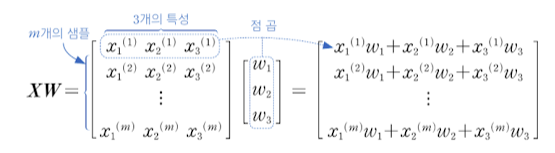

위 그림을 보면 m개의 샘플에 대하여 특성 x1, x2, x3에 가중치 w1, w2, w3를 곱한 다음 더한 값들로 행렬이 만들어짐을 알 수 있음.<br>

<h3>6.1.3 SingleLayer 클래스에 배치 경사 하강법 적용하기</h3>

1. 위스콘신 유방암 데이터 가져오기

In [2]:
import numpy as np
import matplotlib.pyplot as plt

2. 위스콘신 유방암 데이터 세트를 훈련, 검증, 테스트 세트로 나누고 데이터 살펴보기

In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, stratify=y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

3. cancer 데이터 세트의 특성 개수 확인

In [4]:
print(x_train.shape, x_val.shape)

(364, 30) (91, 30)


4. 정방향 계산을 행렬 곱셈으로 표현하기

당므은 정방향 계산을 행렬 곱셈으로 표현한 것임.<br>
훈련 세트와 가중치를 곱한 다음 절편을 더함.

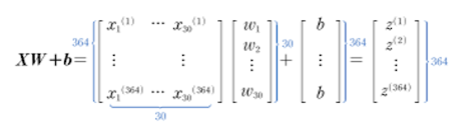

넘파이를 사용하면 절편을 더하는 계산을 위해 (364, 1) 크기의 행렬을 따로 만들 필요가 없음.<br>
행렬에 스칼라 값을 더하면 자동으로 행렬의 각 요소에 스칼라 값을 더해 줌.

5. 그라디언트 계산 이해하기

그라디언트는 오차와 입력 데이터의 곱이므로 다음과 같은 행렬 곱셈으로 표현할 수 있음.

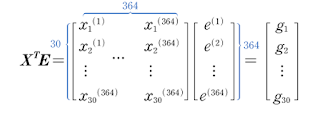

행렬을 전치하면 행과 열이 바뀌므로 샘플의 각 특성들을 오차에 곱할 수 있는 형태가 됨.<br>
g1은 모든 샘플의 첫 번째 특성과 오차를 곱하여 더한 값이므로 이후 그라디언트 평균값을 계산할 때 이 값을 다시 전체 샘플수로 나눔.

6. forpass(), backprop() 메서드에 배치 경사 하강법 적용<br>

행렬 곱셈을 적용한 결과가 그라디언트들의 합이므로 전체 샘플 개수로 나눠 평균 그라디언트를 구함.

In [5]:
class SingleLayer(SingleLayer):
    def forpass(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def backprop(self, x, err) :
        m = len(x)
        w_grad = np.dot(x.T, err) / m
        b_grad = np.sum(err) / m
        return w_grad, b_grad

7. fit() 메서드 수정<br>

기존에는 에포크를 위한 for문과 훈련 세트를 순회하기 위한 for문이 있었음.<br>
배치 경사 하강법에서는 forpass() 메서드와 backprop() 메서드에서 전체 샘플을 한번에 계산하므로 두 번째 for문이 삭제됨.

In [6]:
class SingleLayer(SingleLayer):
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)                                    # 타깃을 열 벡터로 바꿈
        y_val = y_val.reshape(-1, 1)                            # 검증용 타깃을 열 벡터로 바꿈
        m = len(x)                                              # 샘플 개수 저장
        self.w = np.ones((x.shape[1], 1))
        self.b = 0                      
        self.w_history.append(self.w.copy())
        for i in range(epochs):
            z = self.forpass(x)     
            a = self.activation(z)    
            err= -(y - a)          
            w_grad, b_grad = self.backprop(x, err) 
            w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m
            self.w -= w_grad * self.lr                     
            self.b -= b_grad * self.lr
            self.w_history.append(self.w.copy())           
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            self.update_val_loss(x_val, y_val)

활성화 출력 a가 열 벡터이므로 이에 맞추어 타깃값을 (m, 1) 크기의 열 벡터로 변환하였고, <br>
평균 손실을 구하기 위해 np.sum() 함수로 각 샘플의 손실을 더한 후 전체 샘플의 개수로 나눔.

8. 나머지 메서드 수정하기

predict() 메서드에서 사용했던 리스트 내포와 update_val_loss() 메서드도 더 간단해짐.<br>
두 메서드의 코드는 다음과 같음.

In [7]:
class SingleLayer(SingleLayer):
    def predict(self, x) :
        z = self.forpass(x)
        return z > 0
    
    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)
        a = self.activation(z)
        a = np.clip(a, 1e-10, 1-1e-10)
        val_loss = np.sum(-(y_val*np.log(a) + (1-y_val)*np.log(1-a)))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

9. 훈련 데이터 표준화 전처리하기<br>

안정적인 학습을 위해 5장에서 했던 사이킷런의 StandardScaler 클래스를 사용해 데이터 세트의 특성을 평균이 0, 표준 편차가 1이 되게 변환.<br>
이런 데이터 전처리에 관련된 클래스는 sklearn.preprocessing 모듈에 있으며 이런 클래스를 변환기(transformer)라고 부름.

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_val_scaled = scaler.transform(x_val)

10. 이 데이터를 SingleLayer 클래스 객체에 전달하여 배치 경사 하강법을 적용함.

In [9]:
single_layer = SingleLayer(l2=0.01)
single_layer.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val= y_val, epochs=10000)
single_layer.score(x_val_scaled, y_val)

0.978021978021978

확률적 경사 하강법과 배치 경사 하강법은 에포크마다 가중치 업데이트를 하는 횟수에 차이가 있음.<br>
예를 들어 훈련 세트의 샘플 개수가 364개일 때 확률적 경사 하강법은 100번의 에포크를 수행하면 총 36,400번의 가중치 업데이트를 함.<br>
그래서 그래프로 그리면 흔들리는 형태로 나오지만 목표를 향해 빠르게 전진함.<br>
반면 배치 경사 하강법은 전체 훈련 세트를 한 번에 계산한 다음 오차를 역전파하므로 100번의 에포크를 돌리면 100번만 업데이트 됨.

11. 검증 세트로 성능 측정하고 그래프로 비교하기

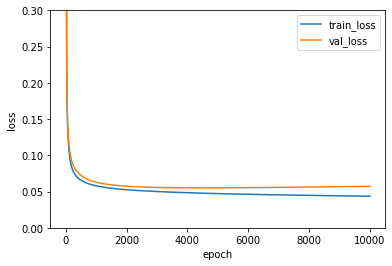

In [10]:
plt.ylim(0, 0.3)
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

배치 경사 하강법은 전체 샘플을 사용해 가중치를 업데이트 하므로 손실값이 안정적으로 감소함.

12. 왜 이런 결과가 나오는지 가중치의 변화를 그래프로 나타내 봄.

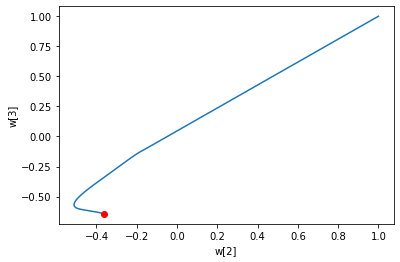

In [11]:
w2 = []
w3 = []
for w in single_layer.w_history:
    w2.append(w[2])
    w3.append(w[3])
plt.plot(w2, w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

배치 경사 하강법을 적용하면 가중치를 찾는 경로가 다소 부드러운 곡선의 형태를 띔.<br>
가중치의 변화가 연속적이므로 손실값도 안정적으로 수렴함.<br>
하지만 연산 비용이 많이 들고 최솟값에 수렴하는 시간도 많이 듦.

<h1>6.2 2개의 층을 가진 신경망 구현</h1>

지금까진 하나의 층에 하나의 뉴런을 사용한 신경망 알고리즘을 배움.<br>
지금부터는 하나의 층을 추가해 보고 층에 있는 뉴런의 개수도 늘려봄.

<h3>6.2.1 하나의 층에 여러 개의 뉴런을 사용</h3>

하나의 뉴런만 사용한 경우 출력의 개수가 1이므로 가중치는 열 벡터가 됨.<br>
여기서 여러 개의 뉴런을 사용함으로써 가중치는 2차원 행렬이 나옴.

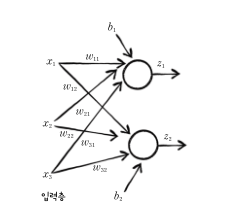

<h3>6.2.2 출력을 하나로 모음</h3>

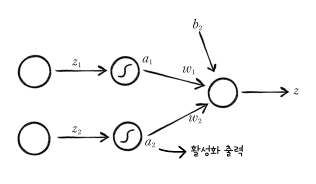

z1, z2는 마지막 뉴런으로 모으기 전의 출력값이고 a1, a2는 활성화 함수에 통과시킨 값임.<br>
(편의상 활성화 출력이라 부름)<br>
2개의 활성화 출력이 마지막 뉴런에 입력되고 여기에 절편이 더해져 z가 만들어짐.<br>

<h3>6.2.3 은닉층이 추가된 신경망을 알아봄</h3>

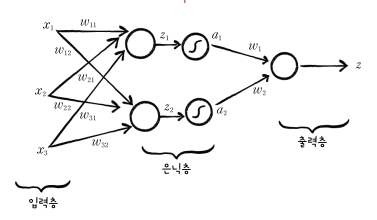

2개의 뉴런과 2개의 층을 가진 신경망이 만들어짐.<br>
입력값이 모인 입력층은 보통 층의 개수에 포함시키지 않음.<br>

입력과 출력은 간단하게 다음과 같이 행렬로 표기함.

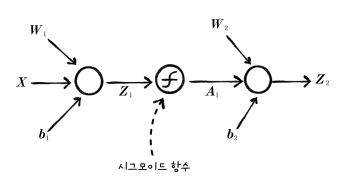

<h3>6.2.4 다층 신경망의 개념을 정리함</h3>

다층 신경망의 각 층은 2개 이상의 뉴런으로 구성함.<br>
앞에서 본 다층 신경망의 은닉층의 뉴런 개수를 2개가 아닌 m개로 늘려 생각해 봄.<br>
(이때 활성화 함수는 뉴런 오른쪽 작은 원으로 표시함)<br>

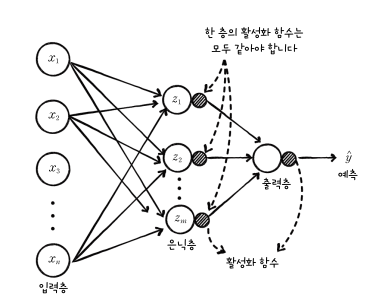

그림은 n개의 입력이 m개의 뉴런으로 입력됨.<br>
그리고 은닉층을 통과한 값들은 다시 출력층으로 모임.<br>
이것을 우리는 딥 러닝이라고 부름.<br>

1. 활성화 함수는 층마다 다를 수 있지만 한 층에서는 같아야 함.<br>

각층은 하나 이상의 뉴런을 가지는데, 은닉층과 출력층에 있는 모든 뉴런에는 활성화 함수가 필요함.<br>
단, 같은 층에 있는 뉴런은 모두 같은 활성화 함수를 사용해야 함.<br>

2. 모든 뉴런이 연결되어 있으면 '완전 연결 신경망'이라고 함.<br>

위의 신경망은 입력층과 은닉층, 은닉층과 출력층 사이의 뉴런들이 모두 연결되어 있으므로 완전 연결(fully-connected) 신경망이라 부름.<br>

<h3>6.2.5 다층 신경망에 경사 하강법을 적용함</h3>

다층 신경망에 경사 하강법을 적용해봄.<br>

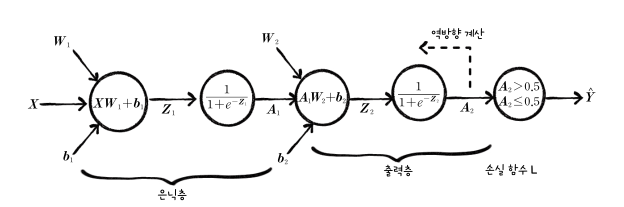

1. 가중치에 대해 손실 함수를 미분함(출력층) <br>

W2에 대한 손실 함수의 미분을 연쇄 법칙으로 풀어 쓰면 다음과 같음.<br>

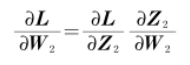

위의 식을 신경망에 적용하면 다음과 같음.<br>

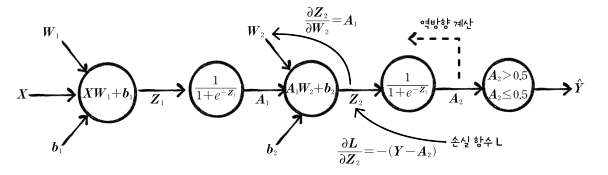

<h3>6.2.6 2개의 층을 가진 신경망 구현</h3>

1. SingleLayer 클래스를 상속한 Dual Layer 클래스 만들기

In [12]:
class DualLayer(SingleLayer):
    def __init__(self, units=10, learning_rate=0.1, l1=0, l2=0):
        self.units = units        # 은닉층 뉴런 개수
        self.w1 = None            # 은닉층 가중치
        self.b1 = None            # 은닉층 절편
        self.w2 = None            # 출력층 가중치
        self.b2 = None            # 출력층 절편
        self.a1 = None            # 은닉층의 활성화 출력
        self.losses = []
        self.val_losses = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2

2. forpass() 메서드 수정하기<br>

이 메서드는 은닉층의 활성화 함수를 통과한 a1과 출력층의 가중치 w2를 곱하고 b2를  더해 최종 출력 z2를 반환함.

In [13]:
class DualLayer(DualLayer):
    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1
        self.a1 = self.activation(z1)
        z2 = np.dot(self.a1, self.w2) + self.b2
        return z2

3. backprop() 메서드 수정하기

In [14]:
class DualLayer(DualLayer):
    def backprop(self, x, err):
        m = len(x)             # 샘플 개수
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        # 시그모이드 함수까지 그라디언트 계산
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        # 은닉층의 가중치와 절편에 대한 그라디언트 계산
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad

w1_grad와 b1_grad는 다음의 수식을 계산한 것임.

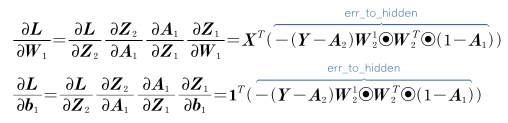

4. fit() 메서드 수정하기

은닉층과 출력층의 가중치, 절편을 초기화하고 에포크마다 정방향 계산을 수행하여 오차를 계산함.<br>
그런 다음 오차를 역전파하여 가중치와 절편의 그라디언트를 계산함.<br>
마지막으로 손실을 계산하여 누적함.<br>

SingleLayer에서는 fit() 메서드를 한 덩어리로 작성했지만,<br>
DualLayer에서는 fit() 메서드를 3개의 작은 메서드로 쪼개서 진행함.

5. fit() 메서드의 가중치 초기화 부분을 init_weights() 메서드로 분리함.<br>

이 메서드는 입력 특성의 개수를 지정하는 n_features 매개변수를 하나 가짐.

In [15]:
class DualLayer(DualLayer):
    def init_weights(self, n_features):
        self.w1 = np.ones((n_features, self.units))    # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)                 # 은닉층의 크기
        self.w2 = np.ones((self.units, 1))             # (은닉층의 크기, 1)
        self.b2 = 0

6. fit() 메서드의 for문 안에 있는 코드 중 일부를 training() 메서드로 분리함.<br>

정방향 계산과 그라디언트를 업데이트하는 코드를 training() 메서드로 옮김.<br>
이 메서드는 훈련 데이터 x, y와 훈련 샘플의 개수 m을 매개변수로 받고 마지막 출력층의 활성화 출력 a를 반환함.

In [16]:
class DualLayer(DualLayer):
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)   # 타깃을 열 벡터로 바꿈
        y_val = y_val.reshape(-1, 1)
        m = len(x)
        self.init_weights(x.shape[1])    # 은닉층과 출력층의 가중치를 초기화함
        #epochs 만큼 반복함
        for i in range(epochs):
            a = self.training(x, y, m)
            a = np.clip(a, 1e-10, 1-1e-10)
            loss = np.sum(-(y*np.log(a) + (1-y)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / m)
            self.update_val_loss(x_val, y_val)
            
    def training(self, x, y, m):
        z = self.forpass(x)
        a =  self.activation(z)
        err = -(y-a)
        
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a

7. reg_loss() 메서드 수정하기<br>

reg_loss() 메서드는 은닉층과 출력층의 가중치에 대한 L1, L2 손실을 계산함.

In [17]:
class DualLayer(DualLayer):
    def reg_loss(self):
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
                self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

<h3>6.2.7 모델 훈련하기</h3>

1. 다층 신경망 모델 훈련하고 평가하기<br>

L2 규제는 0.01만큼, 에포크는 20,000번으로 지정함.<br>

In [18]:
dual_layer = DualLayer(l2=0.01)
dual_layer.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs = 20000)
dual_layer.score(x_val_scaled, y_val)

0.978021978021978

2. 훈련 손실과 검증 손실 그래프 분석하기

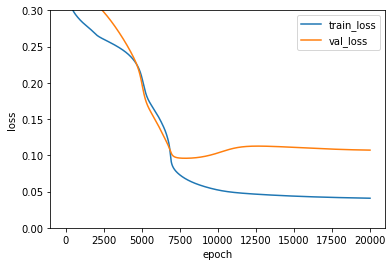

In [19]:
plt.ylim(0, 0.3)
plt.plot(dual_layer.losses)
plt.plot(dual_layer.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

손실 그래프가 이전보다 천천히 감소함.<br>
이는 SingleLayer 클래스보다 가중치의 개수가 훨씬 많아져 학습하는 데 시간이 오래 걸리기 때문임.<br>
위스콘신 유방암 데이터는 특성이 30개이므로 SingleLayer 클래스를 사용하면 가중치 30개와 절편 1개가 필요함.<br>
반면에 DualLayer 클래스는 은닉층의 뉴런이 10개 이므로 30x10 개의 가중치와 10개의 절편이 필요하고,<br>
출력층 역시 10개의 가중치와 1개의 절편이 필요함.<br>
즉, DualLayer 모델은 총 321개의 가중치를 학습해야 함.

<h3>6.2.8 가중치 초기화 개선하기</h3>

손실 그래프를 보면 초기 손실값이 감소하는 곡선이 매끄럽지 못함.<br>
이는 손실 함수가 감소하는 방향을 올바르게 찾는 데 시간이 많이 소요된 것임.<br>
이는 가중치 초기화와 관련이 깊음.<br>

지금까지는 가중치를 1로 놓고 훈련을 진행함.<br>
이번에는 넘파이의 random.normal() 함수를 사용하여 정규 분포를 따르는 무작위 수로 가중치를 초기화함.<br>

1. 가중치 초기화를 위한 init_weights() 메서드 수정하기<br>

DualLayer 클래스를 상속한 RandomInitNetwork 클래스를 만들고 가중치를 초기화하는 init_weights() 메서드만 고침.<br>
normla() 함수의 매개변수는 순서대로 평균, 표준 편차, 배열 크기임.

In [20]:
class RandomInitNetwork(DualLayer):
    def init_weights(self, n_features):
        np.random.seed(42)
        self.w1 = np.random.normal(0, 1, (n_features, self.units))
        self.b1 = np.zeros(self.units)
        self.w2 = np.random.normal(0, 1, (self.units, 1))
        self.b2 = 0

2. 코드를 수정했다면 다음과 같이 RandomInitNetwork 클래스 객체를 다시 만들고 모델을 훈련시킴.

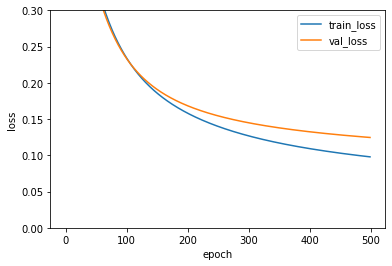

In [21]:
random_init_net = RandomInitNetwork(l2=0.01)
random_init_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)

plt.ylim(0, 0.3)
plt.plot(random_init_net.losses)
plt.plot(random_init_net.val_losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

이젠 손실 함수가 감소하는 곡선이 매끄러움.<br>
가중치를 모두 1로 초기화한 것보다 훨씬 빠르게 손실 함수 값이 줄어듦.

<h1>6.3 미니 배치를 사용하여 모델을 훈련함.</h1>

딥러닝에서는 종종 아주 많은 데이터를 사용하는데 배치 경사 하강법은 이런 경우 사용하기 힘듦.<br>
실전에서는 주로 미니 배치를 사용함.

<h3>6.3.1 미니 배치 경사 하강법을 알아봄</h3>

미니 배치 경사 하강법은 에포크마다 전체 데이터를 사용하는 것이 아니라 조금씩 나누어 정방향 계산을 수행하고 그라디언트를 구하여 가중치를 업데이트함.<br>
미니 배치의 크기는 보통 16, 32, 64 등 2의 배수를 사용함.<br>

미니 배치의 크기는 하이퍼파라미터이고 튜닝의 대상임.<br>
(작으면 확률적 경사 하강법이, 크면 배치 경사 하강법이 되므로)

<h3>6.3.2 미니 배치 경사 하강법을 구현함</h3>

1. MinibatchNetwork 클래스 구현하기<br>

배치 크기를 입력받아야 하므로 \_\_init__ 메서드에 batch_size 매개변수를 추가함.

In [22]:
class MinibatchNetwork(RandomInitNetwork):
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        super().__init__(units, learning_rate, l1, l2)
        self.batch_size = batch_size

2. fit() 메서드 수정하기<br>

에포크를 순회하는 for문 안에 미니 배치를 순회하는 for문이 추가됨.

In [23]:
class MinibatchNetwork(MinibatchNetwork):
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y_val = y_val.reshape(-1, 1)
        self.init_weights(x.shape[1])
        np.random.seed(42)
        for i in range(epochs):
            loss = 0
            for x_batch, y_batch in self.gen_batch(x, y):
                y_batch = y_batch.reshape(-1, 1)
                m = len(x_batch)
                a = self.training(x_batch, y_batch, m)
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += np.sum(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a)))
            self.losses.append((loss + self.reg_loss()) / len(x))
            self.update_val_loss(x_val, y_val)

gen_batch() 메서드는 전체 훈련 데이터 x, y를 전달받아 batch_size 만큼 미니 배치를 만들어 반환함.<br>
그런 다음 반환된 미니 배치 데이터 x_batch, y_batch를 training() 메서드에 전달함.<br>
training() 메서드는 그대로 사용하므로 미니 배치 방식을 간단히 구현 가능.<br>
앞의 DualLayer의 fit() 메서드와 다른 점은 샘플 개수 m을 미니 배치마다 계산한다는 것임.

3. gen_batch() 메서드 만들기<br>

gen_batch() 메서드는 파이썬 제너레이터로 구현함.<br>
파이썬 제너레이터는 순차적으로 데이터에 접근할 수 있는 반복 가능한 객체(iterator)를 반환함.<br>
제너레이터를 사용하면 명시적으로 리스트를 만들지 않으면서 필요한 만큼 데이터를 추출할 수 있으므로 메모리 효율적임.<br>
제너레이터 함수를 만드는 방법은 보통의 함수에 yield문을 사용하는 것임.

In [24]:
class MinibatchNetwork(MinibatchNetwork):
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size
        if length % self.batch_size:
            bins += 1                  # 나누어 떨어지지 않을 때
        indexes = np.random.permutation(np.arange(len(x)))   # 인덱스를 섞음
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]    # batch_size 만큼 슬라이싱하여 반환

gen_batch() 메서드는 batch_size만큼씩 x, y 배열을 건너뛰며 미니 배치를 반환함.<br>
확률적 경사 하강법을 사용했을 때와 마찬가지로 gen_batch() 메서드가 호출될 때 마다 (에포크 마다) 훈련 데이터 배열의 인덱스를 섞음.<br>
이는 미니 배치가 똑같은 순서로 반복되지 않게 도와줌.

4. 미니 배치 경사 하강법 적용하기<br>

cancer 데이터 세트에 batch_size를 기본값 32로 하여 훈련함.<br>
그 이후 batch_size를 128로 늘려서 다시 훈련하고 결과를 비교해 봄.

0.978021978021978


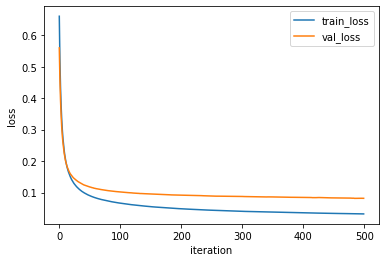

In [25]:
minibatch_net = MinibatchNetwork(l2=0.01, batch_size=32)
minibatch_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)
print(minibatch_net.score(x_val_scaled, y_val))

plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

미니 배치 경사 하강법은 에포크마다 훈련 반복이 여러 번 일어나므로 배치 경사 하강법보다 수렴 속도가 빨라짐.<br>

5. 미니 배치 크기를 늘려서 다시 시도해봄

0.978021978021978


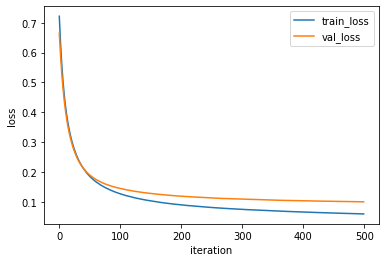

In [26]:
minibatch_net = MinibatchNetwork(l2=0.01, batch_size=128)
minibatch_net.fit(x_train_scaled, y_train, x_val=x_val_scaled, y_val=y_val, epochs=500)
print(minibatch_net.score(x_val_scaled, y_val))

plt.plot(minibatch_net.losses)
plt.plot(minibatch_net.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

batch_size를 128로 늘렸더니 손실 그래프는 조금 더 안정적으로 바뀌었지만 손실 값이 줄어드는 속도가 느려짐.<br>

<h3>6.3.3. 사이킷런을 사용해 다층 신경망 훈련하기</h3>

사이킷런에는 이미 신경망 알고리즘이 구현되어 있음.<br>
사이킷런은 sklearn.neural_network 모듈 아래에 분류 작업을 위한 MLPClassifier, 회귀 작업을 위한 MLPRegressor를 제공함.<br>

1. MLPClassifier의 객체 만들기

In [27]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10, ), activation='logistic', 
                   solver='sgd', alpha=0.01, batch_size=32,
                   learning_rate_init=0.1, max_iter=500)

다음은 MLPClassifier의 주요 매개 변수를 정리한 것임.<br>

<li>은닉층의 크기를 정의하는 hidden_layer_sizes</li>

은닉층의 수와 뉴런의 개수로 튜플을 전달함.<br>
예를 들어 10개의 뉴런을 가진 2개의 은닉층을 만들려면 hidden_layer_sizes=(10,10)과 같이 설정함.<br><br>

<li>활성화 함수를 지정하는 activation</li>

여기서는 시그모이드 함수를 지정하기 위해 activation 매개변수에 logistic을 전달함.<br><br>

<li>경사 하강법 알고리즘의 종류를 지정하는 매개변수 solver</li>

solver 매개변수는 경사 하강법 알고리즘의 종류를 지정함.<br>
기본값은 확률적 경사 하강법을 의미하는 sgd임.<br><br>

<li>규제를 적용하기 위한 매개변수 alpha</li>

사이킷런의 신경망 모델은 L2 규제만 지원함.<br><br>

<li>배치 크기, 학습률 초깃값, 에포크 횟수를 정하는 매개변수 batch_size, learning_rate_init, max_iter</li>

2. 모델 훈련하기

In [28]:
mlp.fit(x_train_scaled, y_train)
mlp.score(x_val_scaled, y_val)

0.989010989010989